In [4]:
"""
importing examples 
├── project (package)
│   ├── src (package)
│   │   ├── __init__.py
│   │   └── utils.py
│   |── clustering.ipynb
    └── __init__.py

import src ---> src.utils.test(10)
from src import utils ---> utils.test(10)
from src.utils import test ---> test(10) 
----------------------------------------
please import each library in its own line 
e.g.

((THIS IS TRUE))
import os
import sys

((THIS IS WRONG))
import os,sys

----------------------------------------
in the package case its ok to import all things in one liune
e.g. 
from src import utils,constants   ((Thats OK !!))
----------------------------------------
import proiority : (very important)
1) Standard library imprts  e.g. sys,os
2) Third party imports e.g. pandas , numpy
3) Local imports e.g. utils , constants and other things inside the project
"""


'\nimporting examples \n├── project (package)\n│   ├── src (package)\n│   │   ├── __init__.py\n│   │   └── utils.py\n│   |── clustering.ipynb\n    └── __init__.py\n\nimport src ---> src.utils.test(10)\nfrom src import utils ---> utils.test(10)\nfrom src.utils import test ---> test(10) \n----------------------------------------\nplease import each library in its own line \ne.g.\n\n((THIS IS TRUE))\nimport os\nimport sys\n\n((THIS IS WRONG))\nimport os,sys\n\n----------------------------------------\nin the package case its ok to import all things in one liune\ne.g. \nfrom src import utils,constants   ((Thats OK !!))\n----------------------------------------\nimport proiority : (very important)\n1) Standard library imprts  e.g. sys,os\n2) Third party imports e.g. pandas , numpy\n3) Local imports e.g. utils , constants and other things inside the project\n'

In [5]:
# Standard libraries Imports
import json
# Third party Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
# Local imports
from src.constants import DATA_API

In [6]:
response = requests.get(DATA_API) # get the data from the API
json_response = json.loads(response.content) # convert the response from binary format to json (dict)
data =pd.DataFrame(json_response) # create the dataframe

In [7]:
data.head()

,hh_id,weight,cms_zone,survey_mode,person_id,person_num,is_participant,first_travel_date,last_travel_date,smartphone_type,...,num_complete_weekend_days,num_complete_weekdays,made_trips,work_cms_zone,school_cms_zone,school_park_amount_day,work_park_amount_week,school_park_amount_week,work_park_amount_month,work_park_amount_day
0,191546322,0.00000,Inner Brooklyn,1,19154632203,3,0,2019-06-24T00:00:00.000,2019-06-30T00:00:00.000,995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,191546322,0.00000,Inner Brooklyn,1,19154632202,2,0,2019-06-24T00:00:00.000,2019-06-30T00:00:00.000,995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,191546322,212.12729,Inner Brooklyn,1,19154632201,1,1,2019-06-24T00:00:00.000,2019-06-30T00:00:00.000,1,...,2,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19241657,0.00000,Middle Queens,1,1924165703,3,0,2019-05-29T00:00:00.000,2019-06-04T00:00:00.000,995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19241657,0.00000,Middle Queens,1,1924165702,2,0,2019-05-29T00:00:00.000,2019-06-04T00:00:00.000,995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_ = data.iloc[:,:25]

In [ ]:
# Check unique values for each feature
obj = data_.nunique()
for key,value in obj.iteritems():
    print(key,",",value)

hh_id , 3346
weight , 2497
cms_zone , 10
survey_mode , 3
person_id , 8286
person_num , 11
is_participant , 2
num_days , 2
num_days_complete , 7
num_trips , 109
num_walk_trips , 68
num_transit_trips , 45
num_bike_trips , 25
num_taxi_trips , 11
num_tnc_trips , 14
num_complete_weekend_days , 3
num_complete_weekdays , 6
first_travel_date , 39
last_travel_date , 40
made_trips , 2
smartphone_type , 5
relationship , 10
age , 11
employment , 6
worker , 3


In [ ]:
data_.dtypes

hh_id                          int64
weight                       float64
cms_zone                      object
survey_mode                    int64
person_id                      int64
person_num                     int64
is_participant                 int64
num_days                     float64
num_days_complete            float64
num_trips                    float64
num_walk_trips               float64
num_transit_trips            float64
num_bike_trips               float64
num_taxi_trips               float64
num_tnc_trips                float64
num_complete_weekend_days    float64
num_complete_weekdays        float64
first_travel_date             object
last_travel_date              object
made_trips                   float64
smartphone_type                int64
relationship                   int64
age                            int64
employment                     int64
worker                         int64
dtype: object

##### hh_id & person_id will be removed, it provides no extra information about the data
##### weight will be provided in the next iteration, we are keeping features in this iteration as simple as possible
##### first_travel_date and last_travel_date will be removed in this iteration, not clearly understandable yet
##### probably data when is_participant equals to 1 will be selected then drop the column, current information: not participant doesn't help in survey information
##### num_days and num_days_complete won't be included in this iteration, need more information about them

In [ ]:
data_with_is_participant_1 =  data_.loc[data_['is_participant'] == 1]
data_with_is_participant_1

,hh_id,weight,cms_zone,survey_mode,person_id,person_num,is_participant,num_days,num_days_complete,num_trips,...,num_complete_weekend_days,num_complete_weekdays,first_travel_date,last_travel_date,made_trips,smartphone_type,relationship,age,employment,worker
2,191546322,212.12729,Inner Brooklyn,1,19154632201,1,1,7.0,7.0,23.0,...,2.0,5.0,06/24/2019,06/30/2019,1.0,1,0,5,6,0
5,19241657,1262.69496,Middle Queens,1,1924165701,1,1,7.0,7.0,15.0,...,2.0,5.0,05/29/2019,06/04/2019,1.0,2,0,5,2,1
6,19933569,92.92534,Middle Queens,1,1993356901,1,1,7.0,7.0,30.0,...,2.0,5.0,06/06/2019,06/12/2019,1.0,2,0,7,7,1
10,19817299,93.97294,Middle Queens,1,1981729901,1,1,7.0,4.0,48.0,...,2.0,2.0,06/16/2019,06/22/2019,1.0,2,0,6,1,1
12,19192971,109.28463,Middle Queens,1,1919297101,1,1,7.0,7.0,45.0,...,2.0,5.0,06/08/2019,06/14/2019,1.0,2,0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8270,19301375,5911.59089,Staten Island,2,1930137501,1,1,1.0,1.0,2.0,...,0.0,1.0,06/13/2019,06/13/2019,1.0,0,0,6,1,1
8273,19766689,78.70592,Staten Island,2,1976668901,1,1,1.0,1.0,0.0,...,0.0,1.0,05/30/2019,05/30/2019,0.0,1,0,8,3,1
8274,19841323,72.75091,Staten Island,2,1984132301,1,1,1.0,1.0,3.0,...,0.0,1.0,05/24/2019,05/24/2019,1.0,3,0,7,1,1
8278,19376768,1357.10850,Staten Island,2,1937676801,1,1,1.0,1.0,4.0,...,1.0,0.0,06/15/2019,06/15/2019,1.0,0,0,4,1,1


In [ ]:
obj = data_with_is_participant_1.nunique()
for key,value in obj.iteritems():
    print(key,",",value)

hh_id , 3346
weight , 2496
cms_zone , 10
survey_mode , 3
person_id , 3346
person_num , 1
is_participant , 1
num_days , 2
num_days_complete , 7
num_trips , 109
num_walk_trips , 68
num_transit_trips , 45
num_bike_trips , 25
num_taxi_trips , 11
num_tnc_trips , 14
num_complete_weekend_days , 3
num_complete_weekdays , 6
first_travel_date , 39
last_travel_date , 40
made_trips , 2
smartphone_type , 4
relationship , 1
age , 8
employment , 5
worker , 2


##### as a result person_num and relationship feature will be deleted because they have on value

In [ ]:
numerical_data = data_.iloc[:,5:17].drop(['num_days','num_days_complete','is_participant'],axis=1)
numerical_data.columns

Index(['person_num', 'num_trips', 'num_walk_trips', 'num_transit_trips',
       'num_bike_trips', 'num_taxi_trips', 'num_tnc_trips',
       'num_complete_weekend_days', 'num_complete_weekdays'],
      dtype='object')

In [ ]:
numerical_data.describe()

,person_num,num_trips,num_walk_trips,num_transit_trips,num_bike_trips,num_taxi_trips,num_tnc_trips,num_complete_weekend_days,num_complete_weekdays
count,8286.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000
mean,2.146633,25.540646,10.004782,5.827555,0.419307,0.111775,0.374776,1.266886,3.067244
std,1.317302,21.900434,12.091553,7.646751,2.141812,1.664201,1.181070,0.843984,1.858192
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,24.000000,5.000000,2.000000,0.000000,0.000000,0.000000,2.000000,4.000000
75%,3.000000,41.000000,16.000000,10.000000,0.000000,0.000000,0.000000,2.000000,5.000000
max,11.000000,178.000000,93.000000,57.000000,36.000000,92.000000,18.000000,2.000000,5.000000


In [ ]:
# display correlation matrix between features
numeric_corr_matrix = numerical_data.select_dtypes(include='number').corr()
numeric_corr_matrix

,person_num,num_trips,num_walk_trips,num_transit_trips,num_bike_trips,num_taxi_trips,num_tnc_trips,num_complete_weekend_days,num_complete_weekdays
person_num,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_trips,NaN,1.000000,0.685732,0.574478,0.162543,0.081621,0.187826,0.494895,0.530072
num_walk_trips,NaN,0.685732,1.000000,0.610044,0.116651,0.021248,0.183317,0.428865,0.468685
num_transit_trips,NaN,0.574478,0.610044,1.000000,0.009034,0.015657,0.135196,0.346632,0.380096
num_bike_trips,NaN,0.162543,0.116651,0.009034,1.000000,0.007480,0.062776,0.090722,0.105136
num_taxi_trips,NaN,0.081621,0.021248,0.015657,0.007480,1.000000,0.033284,0.036010,0.036915
num_tnc_trips,NaN,0.187826,0.183317,0.135196,0.062776,0.033284,1.000000,0.155752,0.166960
num_complete_weekend_days,NaN,0.494895,0.428865,0.346632,0.090722,0.036010,0.155752,1.000000,0.703968
num_complete_weekdays,NaN,0.530072,0.468685,0.380096,0.105136,0.036915,0.166960,0.703968,1.000000


##### NaN = no correlation between, they don't affect/change each other, propably going to be deleted --person_num--
##### regardless the change of person_num, num of trips kinds don't change

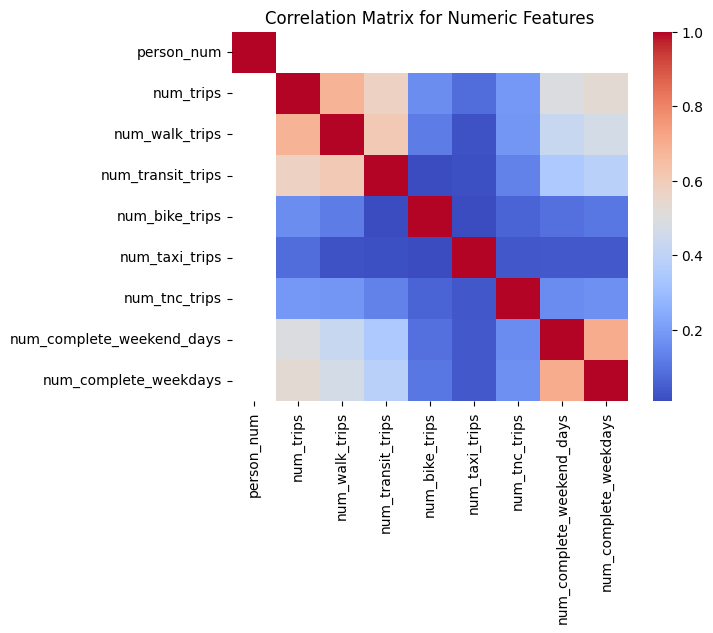

In [ ]:
# Plot a correlation matrix for numeric features
sns.heatmap(numeric_corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()

In [ ]:
categorical_data = data_.iloc[:,19:23]
categorical_data['cms_zone'] = data_['cms_zone']
categorical_data['survey_mode'] = data_['survey_mode']
categorical_data

,made_trips,smartphone_type,relationship,age,cms_zone,survey_mode
0,NaN,995,5,9,Inner Brooklyn,1
1,NaN,995,5,8,Inner Brooklyn,1
2,1.0,1,0,5,Inner Brooklyn,1
3,NaN,995,3,8,Middle Queens,1
4,NaN,995,3,7,Middle Queens,1
...,...,...,...,...,...,...
8281,NaN,995,3,7,Staten Island,2
8282,1.0,0,0,7,Staten Island,2
8283,NaN,995,2,2,Staten Island,2
8284,NaN,995,1,7,Staten Island,2


In [ ]:
categorical_frequency = categorical_data.apply(pd.Series.value_counts)
categorical_frequency

,made_trips,smartphone_type,relationship,age,cms_zone,survey_mode
-9998.0,NaN,NaN,395.0,NaN,NaN,NaN
0.0,309.0,377.0,3346.0,NaN,NaN,NaN
1.0,3037.0,1206.0,1400.0,405.0,NaN,6495.0
2.0,NaN,1747.0,1585.0,871.0,NaN,1538.0
3.0,NaN,16.0,591.0,197.0,NaN,253.0
4.0,NaN,NaN,337.0,795.0,NaN,NaN
5.0,NaN,NaN,233.0,1502.0,NaN,NaN
6.0,NaN,NaN,217.0,1225.0,NaN,NaN
7.0,NaN,NaN,10.0,1186.0,NaN,NaN
8.0,NaN,NaN,NaN,1067.0,NaN,NaN


##### from the frequency matrix -columns features, rows values- 
##### for example count of 1 of survey_mode is the most frequent which means people filled the survey by using rMove (smartphone app)
##### Northern Bronx is the most frequent cms_zone
##### Age values are between 5 and 11, which means 18yo and older
##### most answers from people has iphone mobile 

<AxesSubplot: >

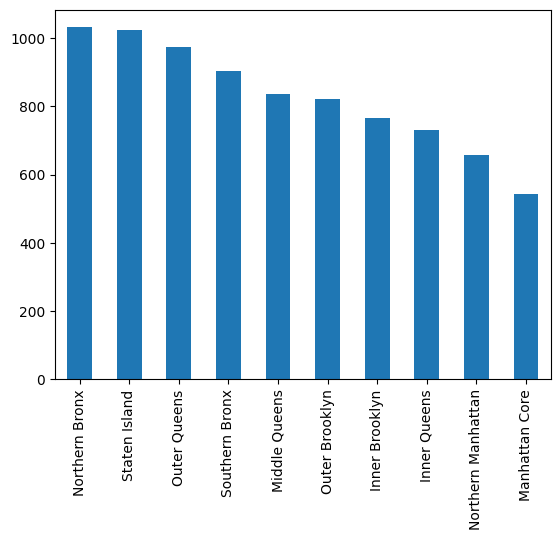

In [ ]:
categorical_data['cms_zone'].value_counts().plot(kind='bar')

In [ ]:
school_numeric_data = data.iloc[:,63:67]
school_numeric_data

,school_park_amount_day,school_park_amount_month,school_park_amount_week,school_park_amount_year
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
8281,NaN,NaN,NaN,NaN
8282,NaN,NaN,NaN,NaN
8283,NaN,NaN,NaN,NaN
8284,NaN,NaN,NaN,NaN


In [ ]:
categorical_school_data = data.iloc[:,25:29]
categorical_school_data = pd.concat([categorical_school_data, data.iloc[:,55:63]], axis=1)
categorical_school_data = pd.concat([categorical_school_data, data.iloc[:,67:78]], axis=1)

In [ ]:
categorical_school_data

,student,license,vehicle,congestion,school_type,school_cms_zone,missing_school_location,kid_accompany,school_mode,school_mode_own,...,school_mode_bus,school_mode_rail,school_mode_ferry,school_access,school_egress,school_mode_taxi,school_mode_bike,school_bike_park,school_mode_scooter,school_scooter_park
0,0,995,995,995,995,NaN,0,995,995,995,...,995,995,995,995,995,995,995,995,995,995
1,0,995,995,995,995,NaN,0,995,995,995,...,995,995,995,995,995,995,995,995,995,995
2,1,1,1,4,10,NaN,1,995,100,6,...,995,995,995,995,995,995,995,995,995,995
3,0,995,995,995,995,NaN,0,995,995,995,...,995,995,995,995,995,995,995,995,995,995
4,0,995,995,995,995,NaN,0,995,995,995,...,995,995,995,995,995,995,995,995,995,995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8281,0,995,995,995,995,NaN,0,995,995,995,...,995,995,995,995,995,995,995,995,995,995
8282,0,1,1,2,995,NaN,0,995,995,995,...,995,995,995,995,995,995,995,995,995,995
8283,1,995,995,995,5,NaN,0,1,100,6,...,995,995,995,995,995,995,995,995,995,995
8284,0,995,995,995,995,NaN,0,995,995,995,...,995,995,995,995,995,995,995,995,995,995


In [ ]:
data['age'].unique()

array([ 9,  8,  5,  7,  6,  4,  3,  1,  2, 10, 11], dtype=int64)

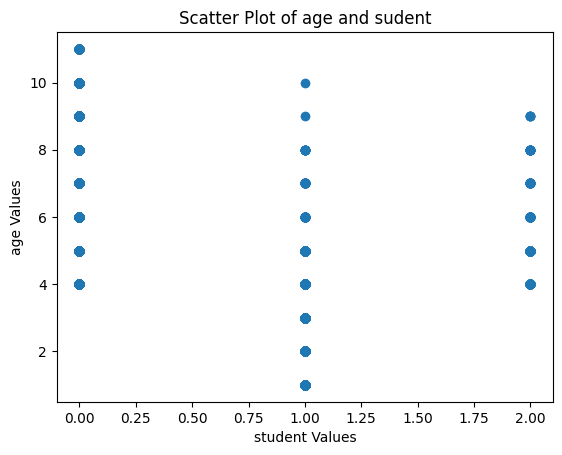

In [ ]:
# Plot a scatter plot of two features
plt.scatter(data['student'], data['age'])
plt.title('Scatter Plot of age and sudent')
plt.xlabel('student Values')
plt.ylabel('age Values')
plt.show()

#### from the plot
##### not students age varies between 4(18-24) and 11(85 or older)
##### full time student age varies between 1(Under 5) //dropped and 10(75-84)
##### half-time student age varies between 4(18-24) and 9(65-74)

In [ ]:
data.loc[data['student'] == 1]['age'].unique()

array([ 5,  3,  1,  2,  4,  6,  7,  8,  9, 10], dtype=int64)

In [ ]:
# dropping age 1 (under 5) // data may be innaccurate
data = data.drop(data[data['age'] == 1].index)

In [ ]:
data.loc[data['student'] == 1]['age'].unique()

array([ 5,  3,  2,  4,  6,  7,  8,  9, 10], dtype=int64)

<AxesSubplot: >

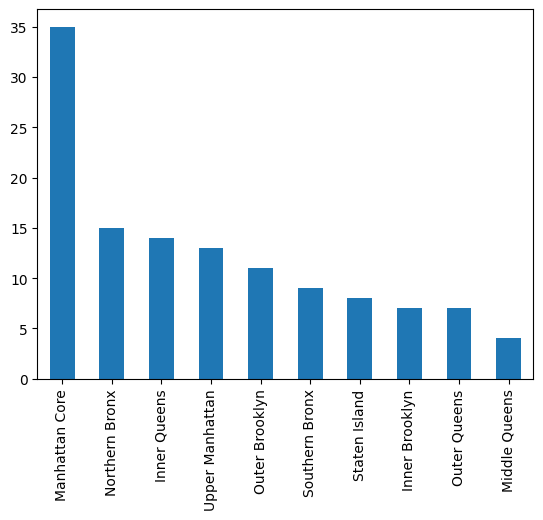

In [ ]:
categorical_school_data['school_cms_zone'].value_counts().plot(kind='bar')

##### Manhattan Core has the highest number of school

<AxesSubplot: >

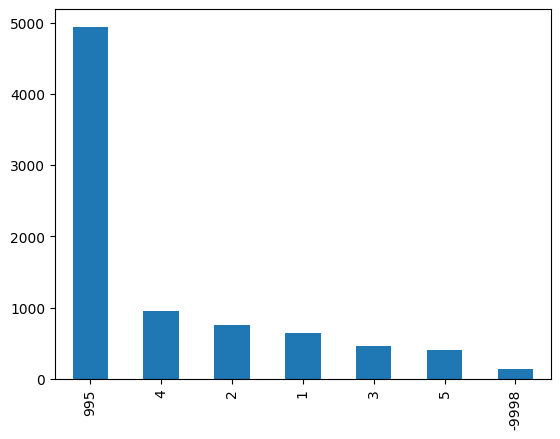

In [ ]:
categorical_school_data['congestion'].value_counts().plot(kind='bar')

##### high number of people don't agree with the policy of congestion pricing (4)

In [ ]:
school_numeric_data.describe()

,school_park_amount_day,school_park_amount_month,school_park_amount_week,school_park_amount_year
count,7.000000,8.000000,5.000000,8.000000
mean,7.892857,23.781250,21.050000,128.156250
std,6.177677,21.036294,28.202615,161.335882
min,0.250000,0.250000,0.250000,0.250000
25%,3.000000,12.250000,4.000000,12.250000
50%,8.000000,18.000000,15.000000,53.000000
75%,12.500000,31.250000,16.000000,212.500000
max,16.000000,60.000000,70.000000,450.000000


In [ ]:
# display correlation matrix between features
numeric_corr_matrix = school_numeric_data.select_dtypes(include='number').corr()
numeric_corr_matrix

,school_park_amount_day,school_park_amount_month,school_park_amount_week,school_park_amount_year
school_park_amount_day,1.0,1.0,1.0,1.0
school_park_amount_month,1.0,1.0,1.0,1.0
school_park_amount_week,1.0,1.0,1.0,1.0
school_park_amount_year,1.0,1.0,1.0,1.0


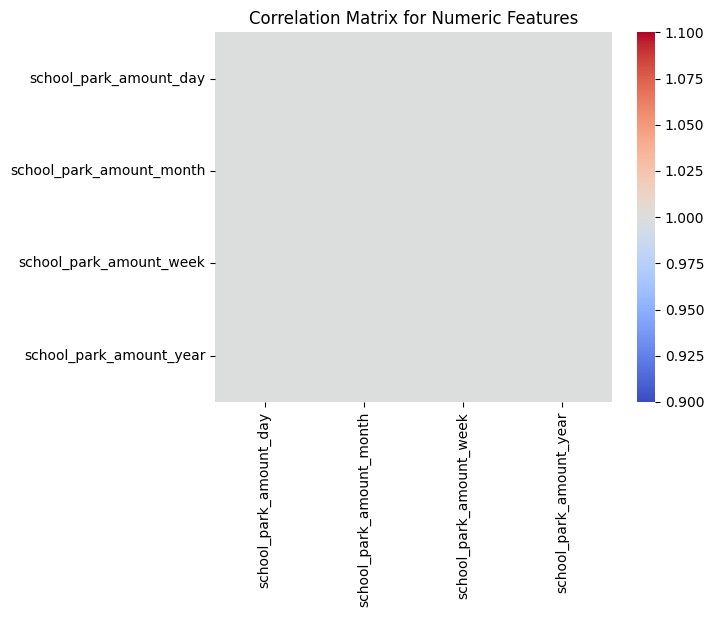

In [ ]:
# Plot a correlation matrix for numeric features
sns.heatmap(numeric_corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()

##### Strong Correlated

In [ ]:
harassment_data = data.iloc[:,135:]
harassment_data

,harassment,harassment_trip,harassment_time,harassment_route,harassment_transit,harassment_mode,harassment_neighborhood,harassment_private_car,harassment_alone,harassment_attention,...,race_native_hawaiian,race_white,race_other,disability_hearing,disability_seeing,disability_walking,disability_mobility,disability_dressing,disability_concentrating,disability_none
0,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
1,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
2,4,995,995,995,995,995,995,995,995,995,...,1,0,0,0,0,0,0,0,0,1
3,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
4,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8281,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
8282,4,995,995,995,995,995,995,995,995,995,...,0,1,0,0,0,0,0,0,0,1
8283,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
8284,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995


In [ ]:
# dropping null data temporary to better visualize the data
harassment_data = harassment_data[harassment_data.harassment != -9998]

In [ ]:
harassment_data = data.iloc[:,135:]
harassment_data

,harassment,harassment_trip,harassment_time,harassment_route,harassment_transit,harassment_mode,harassment_neighborhood,harassment_private_car,harassment_alone,harassment_attention,...,race_native_hawaiian,race_white,race_other,disability_hearing,disability_seeing,disability_walking,disability_mobility,disability_dressing,disability_concentrating,disability_none
0,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
1,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
2,4,995,995,995,995,995,995,995,995,995,...,1,0,0,0,0,0,0,0,0,1
3,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
4,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8281,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
8282,4,995,995,995,995,995,995,995,995,995,...,0,1,0,0,0,0,0,0,0,1
8283,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995
8284,995,995,995,995,995,995,995,995,995,995,...,995,995,995,995,995,995,995,995,995,995


<AxesSubplot: >

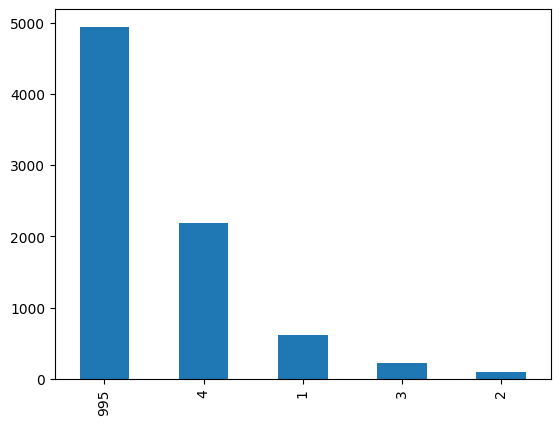

In [ ]:
harassment_data['harassment'].value_counts().plot(kind='bar')

##### most haven't seen or experienced harassment (4)

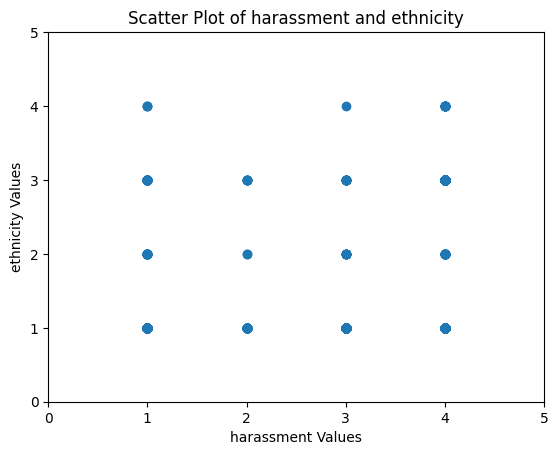

In [ ]:
# Plot a scatter plot of two features
plt.scatter(harassment_data['harassment'], harassment_data['ethnicity'])
plt.title('Scatter Plot of harassment and ethnicity')
plt.xlabel('harassment Values')
plt.ylabel('ethnicity Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### all have seen and/or experienced harassment, and mexican people seem to experience it the most

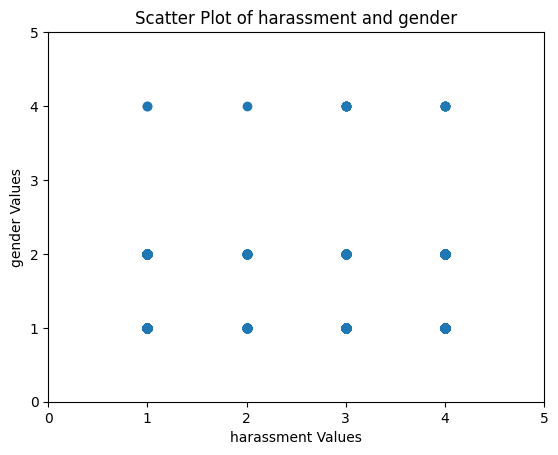

In [ ]:
plt.scatter(harassment_data['harassment'], harassment_data['gender'])
plt.title('Scatter Plot of harassment and gender')
plt.xlabel('harassment Values')
plt.ylabel('gender Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### all genders are equal

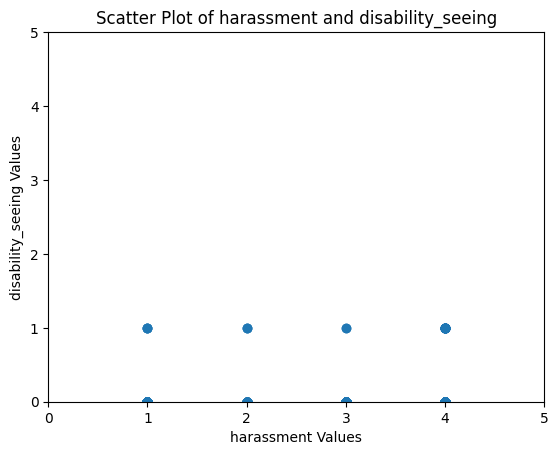

In [ ]:
plt.scatter(harassment_data['harassment'], harassment_data['disability_seeing'])
plt.title('Scatter Plot of harassment and disability_seeing')
plt.xlabel('harassment Values')
plt.ylabel('disability_seeing Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### disabilities doesn't really affect

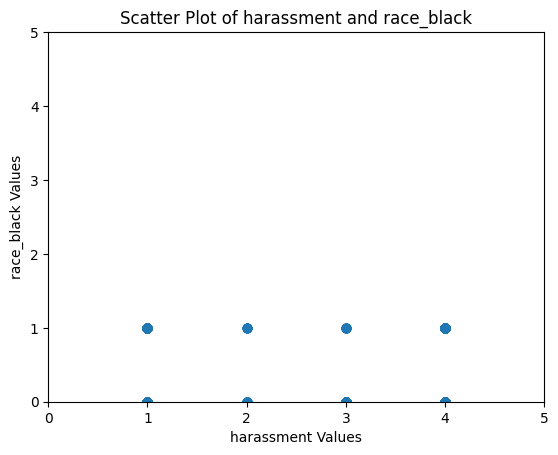

In [ ]:
plt.scatter(harassment_data['harassment'], harassment_data['race_black'])
plt.title('Scatter Plot of harassment and race_black')
plt.xlabel('harassment Values')
plt.ylabel('race_black Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### black or other doesn't affect

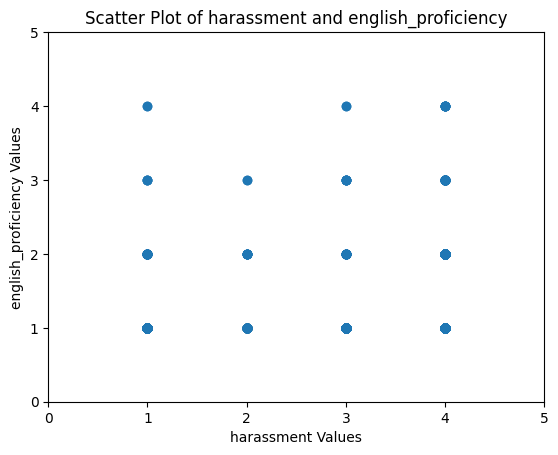

In [ ]:
plt.scatter(harassment_data['harassment'], harassment_data['english_proficiency'])
plt.title('Scatter Plot of harassment and english_proficiency')
plt.xlabel('harassment Values')
plt.ylabel('english_proficiency Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### who speaks english well got harassment

In [ ]:
package_data = data.iloc[:,133:135]

In [ ]:
package_frequency = package_data.apply(pd.Series.value_counts)
package_frequency

,packages,packages_distance
-9998,234,NaN
1,696,44.0
2,1283,98.0
3,312,161.0
4,163,93.0
5,152,29.0
6,150,40.0
7,163,NaN
8,193,NaN
995,4940,7821.0


<AxesSubplot: >

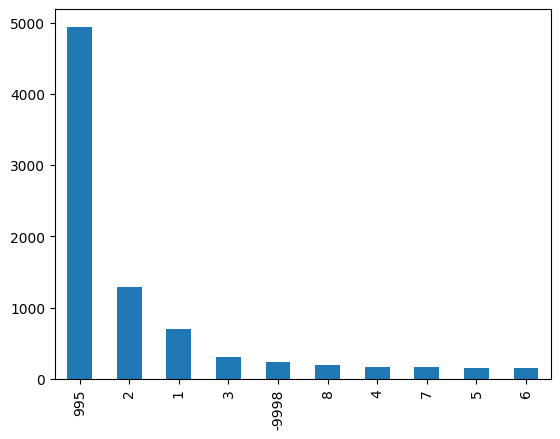

In [ ]:
package_data['packages'].value_counts().plot(kind='bar')

#### most people recieve their packages at their doorsteps

<AxesSubplot: >

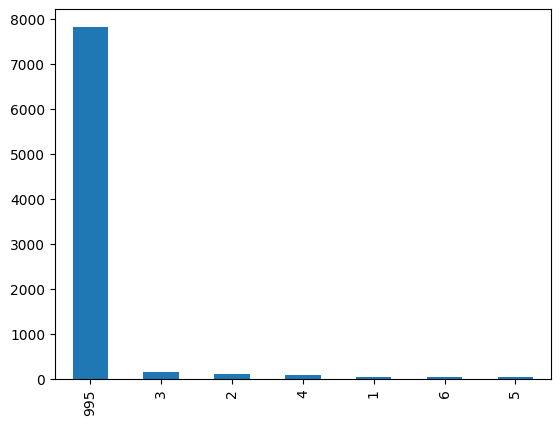

In [ ]:
package_data['packages_distance'].value_counts().plot(kind='bar')

#### most people move 3 blocks away ((around neighbourhood)) to get their packages 
###### 1 block = 15 meters